## Setup and Imports

1. Installing Hugging Face's nlp package
2. Importing libraries

In [1]:
!pip install nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 36.4 MB/s 
     |████████████████████████████████| 212 kB 67.2 MB/s 


Some helper functions that will be helpful later on

In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.8.2


## Importing Data


loading the dataset from the nlp package itself

In [3]:
data = nlp.load_dataset('emotion')

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


Lets take a look at how the dataset looks

In [4]:
data

{'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

As we can see we already have three different dataset. One for training, one for testing and one for validation. This decreases our task of splitting data. Now let us store them in different variables for further processing

In [5]:
train = data['train']
test = data['test']
val = data['validation']

We will now create a function to extract the tweet and its corresponding label from any dataset

In [6]:
def get_data(data):
  tweet = [x['text'] for x in data]
  label = [x['label'] for x in data]
  return tweet, label

We will load the training tweets and its label using the above function

In [7]:
train_tweet, train_label = get_data(train)

In [8]:
#Example tweet and its label
train_tweet[0], train_label[0]

('i didnt feel humiliated', 'sadness')

## Tokenizing the tweets

We can understand words but for us to effectively train a model to understand tweets we have to represent words in tweets in form of numbers, <br> **Tokenisation** is that process of converting words into numbers <br>
What we will do is for each unique word in the corpus of data we will assign it a unique value/token. <br>
We can also set a limit on which words to tokenise, so that we can ignore less common words and give them all a same token indicating unknown/ignore

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

#Create a tokenizer object using the module we jsut imported
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')#we tokenise 10000 most comomon words and the rest are labeled as '<UNK>'

#tokenise our training tweets
tokenizer.fit_on_texts(train_tweet)

Lets see what this tokenisation looks like. We will print the tokens of the first tweet


In [10]:
tokenizer.texts_to_sequences([train_tweet[0]])

[[2, 139, 3, 679]]

The corresponding tweet is:

In [11]:
train_tweet[0]

'i didnt feel humiliated'

## Padding and Truncating Sequences

We will find out what is the average length of our tweets. So we will create a new list and store the length of each tweet in it

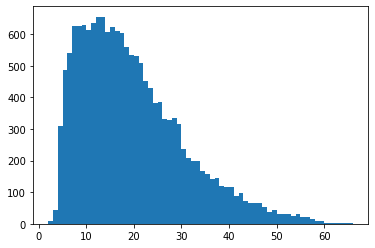

In [12]:
lengths = [len(t.split(" ")) for t in train_tweet]
plt.hist(lengths, bins = len(set(lengths))) #setting the bins to number of unique lenthgs in dataset
plt.show()

We can see most of the tweets are betweeen 10-20 words, and there are almost no tweets more than 60 words

So what we can do now is that if there is any tweet with more than 50 words, we will truncate them, and any tweet with less than 50 words we will pad them with zeroes <br>
All the neural networks require to have inputs that have the same shape and size therefore we need padding and truncating

In [13]:
maxlen = 50 #setting max word length
 
from tensorflow.keras.preprocessing.sequence import pad_sequences

def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post', padding='post', maxlen = maxlen)
  return padded

In [14]:
padded_train_seq = get_sequences(tokenizer, train_tweet)

In [15]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

## Preparing label

In [16]:
#making a set of all the labels to see the unique labels
classes = set(train_label)
print(classes)

{'sadness', 'love', 'fear', 'surprise', 'anger', 'joy'}


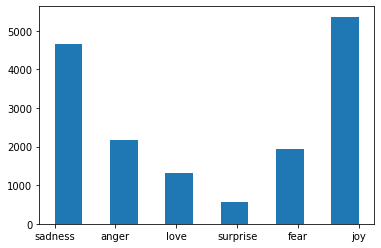

In [17]:
#Plotting the label and its number
plt.hist(train_label, bins = 11)
plt.show()

As we can see that there is a class imbalance, there are a lot of sadness and joy labels which will create a bias in our model. For this project we will not address this issue, as our model will still perform well enough

In [18]:
#Creating two dict for future use
class_to_index = dict((c,v) for v,c in enumerate(classes))
index_to_class = dict((k,v) for v, k in class_to_index.items())

In [19]:
class_to_index

{'sadness': 0, 'love': 1, 'fear': 2, 'surprise': 3, 'anger': 4, 'joy': 5}

In [20]:
index_to_class

{0: 'sadness', 1: 'love', 2: 'fear', 3: 'surprise', 4: 'anger', 5: 'joy'}

In [21]:
name_to_id = lambda label: np.array([class_to_index.get(x) for x in label])

In [22]:
#preparing labels as ids
train_labels = name_to_id(train_label)
print(train_labels)

[0 0 4 ... 5 4 0]


## Creating Model

We create a model with 4 layers including th final dense layer.

In [23]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(10000, 16, input_length = maxlen),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20,return_sequences =True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
    tf.keras.layers.Dense(6, activation= 'softmax')
])

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics=['accuracy']
)

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


## Model Training

In [25]:
#preparing validation set
val_tweets, val_labels = get_data(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = name_to_id(val_labels)

In [26]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 0)

we fit the model with training data and also supply it with the validation data. We train it over 20 epochs(basically cycles) and we put a callback which will stop the training if it sees that further training is not improving the accuracy whatsoever

In [27]:
h = model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq,  val_labels),
    epochs = 20,
    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)
    ]
)

Epoch 1/20
500/500 [==============================] - 16s 15ms/step - loss: 1.2938 - accuracy: 0.4913 - val_loss: 0.7186 - val_accuracy: 0.7435
Epoch 2/20
500/500 [==============================] - 6s 12ms/step - loss: 0.5008 - accuracy: 0.8263 - val_loss: 0.4716 - val_accuracy: 0.8405
Epoch 3/20
500/500 [==============================] - 6s 12ms/step - loss: 0.2816 - accuracy: 0.9035 - val_loss: 0.4264 - val_accuracy: 0.8470
Epoch 4/20
500/500 [==============================] - 6s 12ms/step - loss: 0.1888 - accuracy: 0.9356 - val_loss: 0.4035 - val_accuracy: 0.8740
Epoch 5/20
500/500 [==============================] - 7s 14ms/step - loss: 0.1486 - accuracy: 0.9514 - val_loss: 0.4065 - val_accuracy: 0.8790
Epoch 6/20
500/500 [==============================] - 6s 12ms/step - loss: 0.1189 - accuracy: 0.9611 - val_loss: 0.3601 - val_accuracy: 0.8870
Epoch 7/20
500/500 [==============================] - 6s 12ms/step - loss: 0.0916 - accuracy: 0.9703 - val_loss: 0.4116 - val_accuracy: 0.876

## Evaluate model

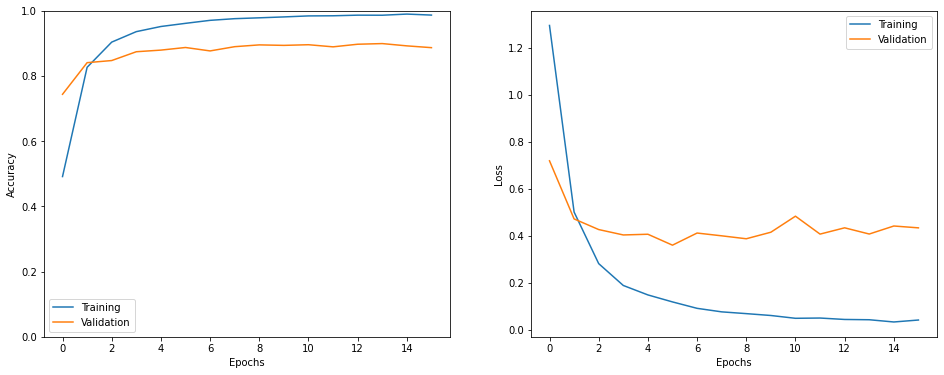

In [29]:
show_history(h)

This graph shows how our model has improved over every epoch

In [30]:
test_tweets, test_labels = get_data(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = name_to_id(test_labels)

In [33]:
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 1s 9ms/step - loss: 0.4336 - accuracy: 0.8930


Our model has performed well on the test data lets try out random tweets and see the result

In [42]:
i = random.randint(0, len(test_labels) - 1)

print('Sentence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis=0))
class_y=np.argmax(p)

print('Predicted Emotion:', index_to_class.get(class_y))

Sentence: i werent feeling crappy enough aunt flo decided to show up and im bloated like a balloon
Emotion: sadness
Predicted Emotion: sadness
